In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

# 하이퍼파라미터
input_data_column_cnt = 5  # 입력데이터의 컬럼 개수(Variable 개수)
output_data_column_cnt = 1 # 결과데이터의 컬럼 개수
 
seq_length = 14           # 1개 시퀀스의 길이(시계열데이터 입력 개수)
rnn_cell_hidden_dim = 20   # 각 셀의 (hidden)출력 크기
forget_bias = 1.0          # 망각편향(기본값 1.0)
num_stacked_layers = 1     # stacked LSTM layers 개수
keep_prob = 1.0            # dropout할 때 keep할 비율
 
epoch_num = 10000          # 에폭 횟수(학습용전체데이터를 몇 회 반복해서 학습할 것인가 입력)
learning_rate = 0.01       # 학습률

def initialize_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    # config.gpu_options.per_process_gpu_memory_fraction = 0.4
    return tf.Session(config=config)
 
# 랜덤에 의해 똑같은 결과를 재현하도록 시드 설정
# 하이퍼파라미터를 튜닝하기 위한 용도(흔들리면 무엇때문에 좋아졌는지 알기 어려움)
tf.set_random_seed(777)
 
# Standardization
def data_standardization(x):
    x_np = np.asarray(x)
    return (x_np - x_np.mean()) / x_np.std()
 
# 너무 작거나 너무 큰 값이 학습을 방해하는 것을 방지하고자 정규화한다
# x가 양수라는 가정하에 최소값과 최대값을 이용하여 0~1사이의 값으로 변환
# Min-Max scaling
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7) # 1e-7은 0으로 나누는 오류 예방차원
 
# 정규화된 값을 원래의 값으로 되돌린다
# 정규화하기 이전의 org_x값과 되돌리고 싶은 x를 입력하면 역정규화된 값을 리턴한다
def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

/etc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# 데이터를 로딩한다.
kospi_file_name = './dataset/kospi(sds_201501~201805).csv' # 코스피지수
encoding = 'euc-kr' # 문자 인코딩
feature_name = ['Date','Current','High','Low','Volume','Trade','Total']
kospi_raw_dataframe = pd.read_csv(kospi_file_name, names=feature_name, encoding=encoding) #판다스이용 csv파일 로딩
kospi_raw_dataframe.info() # 데이터 정보 출력

del kospi_raw_dataframe['Date'] # Date column 삭제

#CSV file의 Header를 제외한 모든 값에 대해서 float 형태로 변환
kospi_info = kospi_raw_dataframe.values[1:].astype(np.float)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 7 columns):
Date       840 non-null object
Current    840 non-null object
High       840 non-null object
Low        840 non-null object
Volume     840 non-null object
Trade      840 non-null object
Total      840 non-null object
dtypes: object(7)
memory usage: 46.0+ KB


In [3]:
# 데이터를 로딩한다.
stock_file_name = './dataset/sds_201501~201805.csv' # 아마존 주가데이터 파일
encoding = 'euc-kr' # 문자 인코딩
names = ['Date','Open','High','Low','Close','Volume']
raw_dataframe = pd.read_csv(stock_file_name, names=names, encoding=encoding) #판다스이용 csv파일 로딩
raw_dataframe.info() # 데이터 정보 출력
 
# raw_dataframe.drop('Date', axis=1, inplace=True) # 시간열을 제거하고 dataframe 재생성하지 않기
del raw_dataframe['Date'] # 위 줄과 같은 효과
 
stock_info = raw_dataframe.values[1:].astype(np.float) # 금액&거래량 문자열을 부동소수점형으로 변환한다
print("stock_info.shape: ", stock_info.shape)
print("stock_info[0]: ", stock_info[0])
print("stock_info[1]: ", stock_info[1])
print("=======================")
print("kospi_info[0]: ", kospi_info[0])
print("kospi_info[1]: ", kospi_info[1])
print("kospi_info[2]: ", kospi_info[2])
print("kospi_info[3]: ", kospi_info[3])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 6 columns):
Date      840 non-null object
Open      840 non-null object
High      840 non-null object
Low       840 non-null object
Close     840 non-null object
Volume    840 non-null object
dtypes: object(6)
memory usage: 39.5+ KB
stock_info.shape:  (839, 5)
stock_info[0]:  [214000. 217000. 211000. 211000. 166820.]
stock_info[1]:  [219000. 221000. 211500. 214000. 124010.]
kospi_info[0]:  [1.92644000e+03 1.92915000e+03 1.90967000e+03 2.58776000e+05
 3.69602900e+06 1.19801025e+09]
kospi_info[1]:  [1.91575000e+03 1.92196000e+03 1.90337000e+03 3.13443000e+05
 4.70013600e+06 1.19152646e+09]
kospi_info[2]:  [1.88245000e+03 1.90002000e+03 1.87738000e+03 3.03688000e+05
 4.75544000e+06 1.17116716e+09]
kospi_info[3]:  [1.88383000e+03 1.88760000e+03 1.87627000e+03 2.80510000e+05
 3.76267700e+06 1.17199082e+09]


In [4]:

# 데이터 전처리
# 가격과 거래량 수치의 차이가 많아나서 각각 별도로 정규화한다
 
# 가격형태 데이터들을 정규화한다
# ['Open','High','Low','Close','Adj Close','Volume']에서 'Adj Close'까지 취함
# 곧, 마지막 열 Volume를 제외한 모든 열
price = stock_info[:,:-1]
norm_price = min_max_scaling(price) # 가격형태 데이터 정규화 처리
print("price.shape: ", price.shape)
print("price[0]: ", price[0])
print("norm_price[0]: ", norm_price[0])
print("="*100) # 화면상 구분용
 
# 거래량형태 데이터를 정규화한다
# ['Open','High','Low','Close','Adj Close','Volume']에서 마지막 'Volume'만 취함
# [:,-1]이 아닌 [:,-1:]이므로 주의하자! 스칼라가아닌 벡터값 산출해야만 쉽게 병합 가능
volume = stock_info[:,-1:]
norm_volume = min_max_scaling(volume) # 거래량형태 데이터 정규화 처리
print("volume.shape: ", volume.shape)
print("volume[0]: ", volume[0])
print("norm_volume[0]: ", norm_volume[0])
print("="*100) # 화면상 구분용

#kospi = kospi_info[:,0] #스칼라값
kospi = kospi_info[:,:1] #백터값
norm_kospi = min_max_scaling(kospi)
print("kospi.shape: ", kospi.shape)
print("kospi[0]: ", kospi[0])
print("norm_kospi[0]: ", norm_kospi[0])
print("="*100) # 화면상 구분용


price.shape:  (839, 4)
price[0]:  [214000. 217000. 211000. 211000.]
norm_price[0]:  [0.41609195 0.42988506 0.40229885 0.40229885]
volume.shape:  (839, 1)
volume[0]:  [166820.]
norm_volume[0]:  [0.04349307]
kospi.shape:  (839, 1)
kospi[0]:  [1926.44]
norm_kospi[0]:  [0.12575809]


In [5]:
# 행은 그대로 두고 열을 우측에 붙여 합친다
x = np.concatenate((norm_price, norm_volume), axis=1) # axis=1, 세로로 합친다
print("x.shape: ", x.shape)
print("x[0]: ", x[0])    # x의 첫 값
print("x[-1]: ", x[-1])  # x의 마지막 값
print("="*100) # 화면상 구분용
 
y = x[:, [-2]] # 타켓은 주식 종가이다
print("y.shape: ", y.shape)
print("y[0]: ",y[0])     # y의 첫 값
print("y[-1]: ",y[-1])   # y의 마지막 값

print("="*100) # 화면상 구분용

x_kospi = norm_kospi
print("x_kospi.shape: ", x_kospi.shape)
print("x_kospi[0]: ",x_kospi[0])     # x_kospi의 첫 값
print("x_kospi[-1]: ",x_kospi[-1])   # x_kospi의 마지막 값

x.shape:  (839, 5)
x[0]:  [0.41609195 0.42988506 0.40229885 0.40229885 0.04349307]
x[-1]:  [0.80229885 0.89885057 0.78850575 0.89425287 0.21590093]
y.shape:  (839, 1)
y[0]:  [0.40229885]
y[-1]:  [0.89425287]
x_kospi.shape:  (839, 1)
x_kospi[0]:  [0.12575809]
x_kospi[-1]:  [0.77201385]


In [6]:
dataX = [] # 입력으로 사용될 Stock Sequence Data
dataY = [] # 출력(타켓)으로 사용
dataX_K = [] # 입력으로 사용될 Kospi Sequence Data
 
for i in range(0, len(y) - seq_length):
    _x = x[i : i+seq_length]
    _y = y[i + seq_length] # 다음 나타날 주가(정답)
    _x_k = x_kospi[i : i+seq_length]
    if i is 0:
        print(_x, "->", _y) # 첫번째 행만 출력해 봄
    dataX.append(_x) # dataX 리스트에 추가
    dataY.append(_y) # dataY 리스트에 추가
    dataX_K.append(_x_k)


# 학습용/테스트용 데이터 생성
# 전체 70%를 학습용 데이터로 사용
train_size = int(len(dataY) * 0.7)
# 나머지(30%)를 테스트용 데이터로 사용
test_size = len(dataY) - train_size
 
# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])
trainX_K = np.array(dataX_K[0:train_size])

print(trainX.shape)
print(trainY.shape)
print(trainX_K.shape)
 
# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])
testX_K = np.array(dataX_K[train_size:len(dataX_K)])

[[0.41609195 0.42988506 0.40229885 0.40229885 0.04349307]
 [0.43908046 0.44827586 0.4045977  0.41609195 0.02922534]
 [0.44597701 0.45287356 0.43908046 0.44597701 0.00593272]
 [0.46666667 0.46896552 0.44367816 0.44827586 0.01468833]
 [0.46896552 0.47126437 0.45287356 0.46666667 0.01520991]
 [0.44137931 0.45517241 0.42758621 0.45287356 0.01375448]
 [0.44367816 0.45517241 0.43678161 0.43908046 0.01832541]
 [0.45977011 0.46206897 0.44137931 0.45977011 0.00770944]
 [0.44827586 0.45517241 0.44137931 0.44827586 0.01108857]
 [0.45057471 0.46436782 0.44597701 0.45287356 0.01032169]
 [0.45517241 0.45747126 0.43678161 0.45287356 0.00485323]
 [0.44597701 0.45977011 0.43678161 0.44137931 0.01410809]
 [0.45977011 0.47816092 0.44597701 0.45057471 0.00866062]
 [0.44137931 0.46206897 0.43908046 0.45977011 0.00918554]] -> [0.45287356]
(577, 14, 5)
(577, 1)
(577, 14, 1)


In [7]:
# 텐서플로우 플레이스홀더 생성
# 입력 X, 출력 Y를 생성한다
X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt])
print("X: ", X)
Y = tf.placeholder(tf.float32, [None, 1])
print("Y: ", Y)
X_K = tf.placeholder(tf.float32, [None, seq_length, 1])
print("X Kospi: ", X_K)
 
# 검증용 측정지표를 산출하기 위한 targets, predictions를 생성한다
targets = tf.placeholder(tf.float32, [None, 1])
print("targets: ", targets)
 
predictions = tf.placeholder(tf.float32, [None, 1])
print("predictions: ", predictions)
 
# 모델(LSTM 네트워크) 생성
def lstm_cell():
    # LSTM셀을 생성
    # num_units: 각 Cell 출력 크기
    # forget_bias:  to the biases of the forget gate 
    #              (default: 1)  in order to reduce the scale of forgetting in the beginning of the training.
    # state_is_tuple: True ==> accepted and returned states are 2-tuples of the c_state and m_state.
    # state_is_tuple: False ==> they are concatenated along the column axis.
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim, 
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.softsign)
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell
 
# num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
#stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
#multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()

cell1 = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim, 
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.softsign, name='cell1')
cell2 = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim, 
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.softsign, name='cell2')

 
# RNN Cell(여기서는 LSTM셀임)들을 연결
hypothesis, _states = tf.nn.dynamic_rnn(cell1, X, dtype=tf.float32)
print("hypothesis: ", hypothesis)

hypothesis_k, _states_k = tf.nn.dynamic_rnn(cell2, X_K, dtype=tf.float32)
print("hypothesis_k: ", hypothesis_k)

hypothesis = tf.concat([hypothesis, hypothesis_k], axis = -1)
 
# [:, -1]를 잘 살펴보자. LSTM RNN의 마지막 (hidden)출력만을 사용했다.
# 과거 여러 거래일의 주가를 이용해서 다음날의 주가 1개를 예측하기때문에 MANY-TO-ONE형태이다
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_column_cnt, activation_fn=tf.identity)
 
# 손실함수로 평균제곱오차를 사용한다
loss = tf.reduce_sum(tf.square(hypothesis - Y))
# 최적화함수로 AdamOptimizer를 사용한다
optimizer = tf.train.AdamOptimizer(learning_rate)
# optimizer = tf.train.RMSPropOptimizer(learning_rate) # LSTM과 궁합 별로임
 
train = optimizer.minimize(loss)
 
# RMSE(Root Mean Square Error)
# 제곱오차의 평균을 구하고 다시 제곱근을 구하면 평균 오차가 나온다
# rmse = tf.sqrt(tf.reduce_mean(tf.square(targets-predictions))) # 아래 코드와 같다
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(reverse_min_max_scaling(price, targets), 
                                                    reverse_min_max_scaling(price, predictions))))

train_error_summary = [] # 학습용 데이터의 오류를 중간 중간 기록한다
test_error_summary = []  # 테스트용 데이터의 오류를 중간 중간 기록한다
test_predict = ''        # 테스트용데이터로 예측한 결과
 
sess = tf.Session()
sess.run(tf.global_variables_initializer())

 

X:  Tensor("Placeholder:0", shape=(?, 14, 5), dtype=float32)
Y:  Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
X Kospi:  Tensor("Placeholder_2:0", shape=(?, 14, 1), dtype=float32)
targets:  Tensor("Placeholder_3:0", shape=(?, 1), dtype=float32)
predictions:  Tensor("Placeholder_4:0", shape=(?, 1), dtype=float32)
hypothesis:  Tensor("rnn/transpose_1:0", shape=(?, 14, 20), dtype=float32)
hypothesis_k:  Tensor("rnn_1/transpose_1:0", shape=(?, 14, 20), dtype=float32)


In [8]:
 
# 학습한다
start_time = datetime.datetime.now() # 시작시간을 기록한다
print('학습을 시작합니다...')
for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY, X_K:trainX_K})
    if ((epoch+1) % 100 == 0) or (epoch == epoch_num-1): # 100번째마다 또는 마지막 epoch인 경우
        # 학습용데이터로 rmse오차를 구한다
        train_predict = sess.run(hypothesis, feed_dict={X: trainX, X_K:trainX_K})
        train_error = sess.run(rmse, feed_dict={targets: trainY, predictions: train_predict})
        train_error_summary.append(train_error)
 
        # 테스트용데이터로 rmse오차를 구한다
        test_predict = sess.run(hypothesis, feed_dict={X: testX, X_K:testX_K})
        test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary.append(test_error)
        
        # 현재 오류를 출력한다
        print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, train_error, test_error, test_error-train_error))
        
end_time = datetime.datetime.now() # 종료시간을 기록한다
elapsed_time = end_time - start_time # 경과시간을 구한다
print('elapsed_time:',elapsed_time)
print('elapsed_time per epoch:',elapsed_time/epoch_num)
 

학습을 시작합니다...
epoch: 100, train_error(A): 4764.88232421875, test_error(B): 9510.71484375, B-A: 4745.83251953125
epoch: 200, train_error(A): 3682.649658203125, test_error(B): 7154.71728515625, B-A: 3472.067626953125
epoch: 300, train_error(A): 3097.044677734375, test_error(B): 5809.1455078125, B-A: 2712.100830078125
epoch: 400, train_error(A): 2688.973876953125, test_error(B): 4843.7880859375, B-A: 2154.814208984375
epoch: 500, train_error(A): 2354.409912109375, test_error(B): 4278.7568359375, B-A: 1924.346923828125
epoch: 600, train_error(A): 2059.35107421875, test_error(B): 3988.7177734375, B-A: 1929.36669921875
epoch: 700, train_error(A): 1888.430419921875, test_error(B): 4007.2158203125, B-A: 2118.785400390625
epoch: 800, train_error(A): 1822.3076171875, test_error(B): 4004.425537109375, B-A: 2182.117919921875
epoch: 900, train_error(A): 1779.507080078125, test_error(B): 3965.018310546875, B-A: 2185.51123046875
epoch: 1000, train_error(A): 1745.94287109375, test_error(B): 3932.589111

epoch: 8300, train_error(A): 1553.596923828125, test_error(B): 4270.80419921875, B-A: 2717.207275390625
epoch: 8400, train_error(A): 1542.3323974609375, test_error(B): 4328.24462890625, B-A: 2785.912109375
epoch: 8500, train_error(A): 1530.827880859375, test_error(B): 4427.32470703125, B-A: 2896.496826171875
epoch: 8600, train_error(A): 1518.892822265625, test_error(B): 4580.41943359375, B-A: 3061.526611328125
epoch: 8700, train_error(A): 1506.7105712890625, test_error(B): 4770.16455078125, B-A: 3263.4541015625
epoch: 8800, train_error(A): 1494.03466796875, test_error(B): 4972.0458984375, B-A: 3478.01123046875
epoch: 8900, train_error(A): 1480.5953369140625, test_error(B): 5162.3876953125, B-A: 3681.79248046875
epoch: 9000, train_error(A): 1465.8599853515625, test_error(B): 5361.29931640625, B-A: 3895.439453125
epoch: 9100, train_error(A): 1449.4698486328125, test_error(B): 5581.34619140625, B-A: 4131.87646484375
epoch: 9200, train_error(A): 1569.7042236328125, test_error(B): 5797.6518

In [14]:

# 하이퍼파라미터 출력
print('input_data_column_cnt:', input_data_column_cnt, end='')
print(',output_data_column_cnt:', output_data_column_cnt, end='')
 
print(',seq_length:', seq_length, end='')
print(',rnn_cell_hidden_dim:', rnn_cell_hidden_dim, end='')
print(',forget_bias:', forget_bias, end='')
print(',num_stacked_layers:', num_stacked_layers, end='')
print(',keep_prob:', keep_prob, end='')
 
print(',epoch_num:', epoch_num, end='')
print(',learning_rate:', learning_rate, end='')
 
print(',train_error:', train_error_summary[-1], end='')
print(',test_error:', test_error_summary[-1], end='')
print(',min_test_error:', np.min(test_error_summary))
 

input_data_column_cnt: 5,output_data_column_cnt: 1,seq_length: 14,rnn_cell_hidden_dim: 20,forget_bias: 1.0,num_stacked_layers: 1,keep_prob: 1.0,epoch_num: 10000,learning_rate: 0.01,train_error: 1254.1655,test_error: 8717.794,min_test_error: 3914.0166


Text(0,0.5,'Root Mean Square Error')

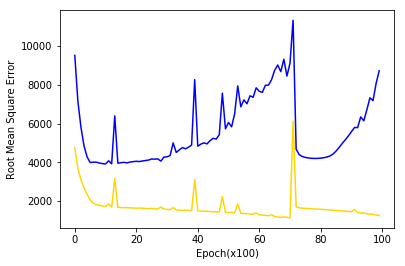

In [10]:
# 결과 그래프 출력

plt.figure(1)
plt.plot(train_error_summary, 'gold')
plt.plot(test_error_summary, 'b')
plt.xlabel('Epoch(x100)')
plt.ylabel('Root Mean Square Error')

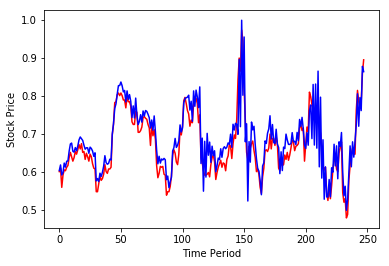

[607.859375]
[1820.984375]
[7096.]
[1350.234375]
[3888.53125]
[2058.265625]
[3443.140625]
[2605.515625]
[3695.375]
[4830.5625]
[7839.625]
[5659.40625]
[3150.4375]
[2257.8125]
[1916.90625]
[2162.3125]
[2644.15625]
[6843.]
[2897.5]
[6852.5625]
[3637.25]
[5850.3125]
[3161.4375]
[5110.625]
[4495.1875]
[4002.5625]
[4751.625]
[7258.65625]
[6760.46875]
[9275.40625]
[6191.84375]
[7516.25]
[1317.0625]
[1597.65625]
[2232.59375]
[3592.59375]
[4603.5]
[5112.1875]
[5155.0625]
[5223.015625]
[3219.65625]
[5602.6875]
[4155.828125]
[510.4375]
[576.9375]
[-3348.125]
[-1176.46875]
[310.34375]
[4220.125]
[5783.75]
[6292.0625]
[5612.8125]
[4636.8125]
[5456.]
[3393.03125]
[2699.5625]
[1367.625]
[4074.8125]
[2704.75]
[2464.34375]
[10621.6875]
[3714.0625]
[7582.1875]
[-1912.46875]
[4414.0625]
[6286.53125]
[9079.6875]
[2818.375]
[3711.4375]
[350.8125]
[4477.9375]
[4484.]
[5831.]
[5878.3125]
[9945.5]
[2535.5625]
[3210.8125]
[7876.25]
[4367.75]
[8704.625]
[7966.390625]
[9776.]
[1889.265625]
[4740.4375]
[3652.156

In [16]:
test_predict = sess.run(hypothesis, feed_dict={X: testX, X_K:testX_K})
test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
test_error_summary.append(test_error)

plt.figure(3)
plt.plot(testY, 'r', label="Real")
plt.plot(test_predict, 'b', label="Predict")
plt.xlabel('Time Period')
plt.ylabel('Stock Price')
plt.show()

testY_ = reverse_min_max_scaling(price,testY)
test_predict_ = reverse_min_max_scaling(price,test_predict)

for r, p in zip(testY_, test_predict_):
    print(p-r)
    

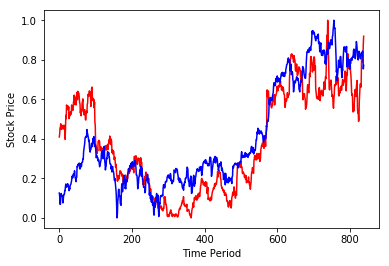

In [12]:
plt.figure(3)
plt.plot(min_max_scaling(stock_info[:,-2]), 'r', label="Real")
plt.plot(min_max_scaling(kospi_info[:,0]), 'b', label="Predict")
plt.xlabel('Time Period')
plt.ylabel('Stock Price')
plt.show()

In [13]:

# sequence length만큼의 가장 최근 데이터를 슬라이싱한다
recent_data = np.array([x[len(x)-seq_length : ]])
print("recent_data.shape:", recent_data.shape)
print("recent_data:", recent_data)
 
# 내일 종가를 예측해본다
test_predict = sess.run(hypothesis, feed_dict={X: recent_data})
 
print("test_predict", test_predict[0])
test_predict = reverse_min_max_scaling(price,test_predict) # 금액데이터 역정규화한다
print("Tomorrow's stock price", test_predict[0]) # 예측한 주가를 출력한다

recent_data.shape: (1, 14, 5)
recent_data: [[[0.57701149 0.57701149 0.47586207 0.48735632 0.26119605]
  [0.6183908  0.62988506 0.57241379 0.57701149 0.10630273]
  [0.64827586 0.66666667 0.6045977  0.61609195 0.04897253]
  [0.65057471 0.65747126 0.63908046 0.64597701 0.02059439]
  [0.65287356 0.67126437 0.64827586 0.66206897 0.03652885]
  [0.65747126 0.67816092 0.63908046 0.64597701 0.07677843]
  [0.74712644 0.74942529 0.62988506 0.64597701 0.31303646]
  [0.79310345 0.8091954  0.76091954 0.76091954 0.0813967 ]
  [0.8091954  0.82298851 0.7954023  0.8137931  0.06405146]
  [0.7816092  0.8137931  0.77471264 0.78390805 0.04997237]
  [0.77701149 0.80229885 0.76781609 0.76781609 0.04666923]
  [0.83678161 0.84597701 0.77701149 0.78390805 0.12276277]
  [0.91494253 0.93793103 0.84827586 0.85747126 0.17242419]
  [0.80229885 0.89885057 0.78850575 0.89425287 0.21590093]]]


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_2' with dtype float and shape [?,14,1]
	 [[Node: Placeholder_2 = Placeholder[dtype=DT_FLOAT, shape=[?,14,1], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: fully_connected/Identity/_59 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_293_fully_connected/Identity", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Placeholder_2', defined at:
  File "/etc/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/etc/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/etc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/etc/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/etc/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/etc/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/etc/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/etc/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/etc/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/etc/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/etc/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/etc/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/etc/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/etc/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/etc/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/etc/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/etc/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/etc/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/etc/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/etc/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-5080d3465d41>", line 7, in <module>
    X_K = tf.placeholder(tf.float32, [None, seq_length, 1])
  File "/etc/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1808, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/etc/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4848, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/etc/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/etc/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/etc/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_2' with dtype float and shape [?,14,1]
	 [[Node: Placeholder_2 = Placeholder[dtype=DT_FLOAT, shape=[?,14,1], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: fully_connected/Identity/_59 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_293_fully_connected/Identity", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
raw_dataframe.head()

In [ ]:
stock_file_name = './dataset/AMZN.csv' # 아마존 주가데이터 파일
encoding = 'euc-kr' # 문자 인코딩
names = ['Date','Open','High','Low','Close','Adj Close','Volume']
raw_dataframe = pd.read_csv(stock_file_name, names=names, encoding=encoding)

In [ ]:
raw_dataframe.tail()